In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("simchrom_novel_struct_domains_241.csv")
df.to_json("data_domains.json", orient="records")
start = f'{{"recordsTotal": {df.shape[0]},\n "recordsFiltered": {df.shape[0]}, \n  "data":'
!echo '{start}' > data_domains_n.json
!cat  data_domains.json >> data_domains_n.json
!echo '}' >> data_domains_n.json

In [11]:
df = pd.read_csv("protein_localization_info.csv")
df.to_json("data.json", orient="records")

In [12]:
!echo '{"data":' | cat - data.json > data_n.json
!echo '}' >> data_n.json

In [49]:
f = 'PHD'
df[df['Protein domains and families (by PFAM)'].map(lambda x: sum([a.split('(')[0] == f for a in str(x).split(';')]))>1].shape

(17, 20)

In [27]:
df[df.iloc[:,17].map(lambda x: 'PWWP' in str(x))].shape

(26, 20)

In [6]:
# plot1

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpld3
import numpy as np
import seaborn as sns
import pandas as pd

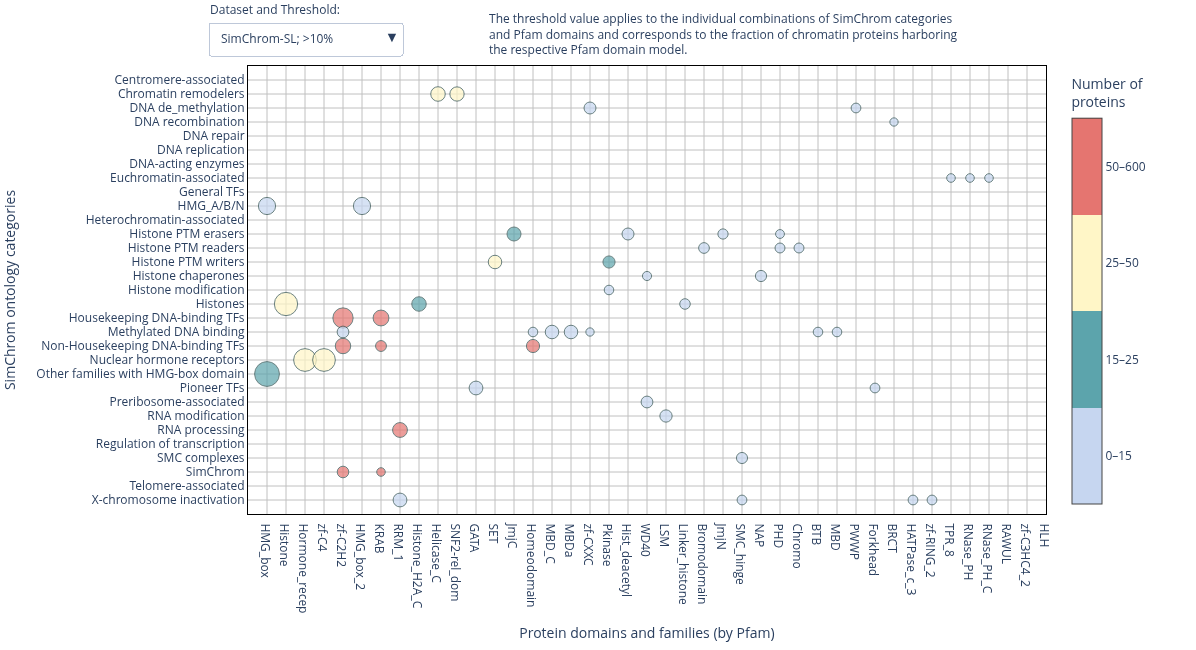

In [25]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Load data
df_perc_sl = pd.read_csv("simchrom_sl_domains_percent_0_1.csv", index_col=0).sort_index()
df_size_sl = pd.read_csv("simchrom_sl_domains_number_0_1.csv", index_col=0).sort_index()
df_perc = pd.read_csv("simchrom_domains_percent_0_1.csv", index_col=0).sort_index()
df_size = pd.read_csv("simchrom_domains_number_0_1.csv", index_col=0).sort_index()

column_order = (pd.DataFrame([df_perc.max(),df_perc_sl.max()])//5).T.sort_values([1,0],ascending=False).index

df_perc_sl = df_perc_sl[column_order]
df_size_sl = df_size_sl[column_order]
df_perc = df_perc[column_order]
df_size = df_size[column_order]

def map_color(val):
    if val < 15:
        return 0.2
    elif val < 25:
        return 0.3
    elif val < 50:
        return 0.6
    else:
        return 0.8
    
colorscale = [
    [0.0, "#c6d6f0"],
    [0.25, "#c6d6f0"],
    [0.25, "#5ca4ac"],
    [0.5, "#5ca4ac"],
    [0.5, "#fff6c7"],
    [0.75, "#fff6c7"],
    [0.75, "#e57570"],
    [1.0, "#e57570"],
]

def make_trace(df_perc, df_size, threshold):
    n_rows, n_cols = df_size.shape
    x, y = np.meshgrid(np.arange(n_cols), np.arange(n_rows))
    x = x.flatten()
    y = y.flatten()

    sizes = df_perc.values.flatten()
    colors = df_size.values.flatten()

    mask = sizes >= threshold
    x_all = x[mask]
    y_all = y[mask]
    sizes_all = sizes[mask]
    colors_all = colors[mask]
    color_cats = [map_color(val) for val in colors_all]

    return go.Scatter(
        x=x_all,
        y=y_all,
        text=[
            f"{percent:.1f}%, {num:n} proteins"
            for num, percent in zip(colors_all, sizes_all)
        ],
        name='',
        mode="markers",
        marker=dict(
            color=color_cats,
            colorscale=colorscale,
            cmin=0,
            cmax=1,
            colorbar=dict(
                tickvals=[i/4+1/8 for i in range(4)], 
                ticktext=["0–15","15–25","25–50","50–600"],
                title="Number of<br>proteins"
            ),
            size=sizes_all,
            opacity=0.7,
            sizemode="area",
            sizeref=0.3,
            line_width=1,
            line_color="DarkSlateGrey"
        ),
        showlegend=False,
        visible=False
    )

thresholds = [0.1, 5, 10]
data = []

# Create all traces
for df_p, df_s in [(df_perc, df_size), (df_perc_sl, df_size_sl)]:
    for th in thresholds:
        trace = make_trace(df_p, df_s, th)
        data.append(trace)

# Set default visible trace
data[-1].visible = True

# Dropdowns
n_thresholds = len(thresholds)
thresholds_max_x = [df_size.shape[1],(df_perc_sl.max()>=5).sum()+2,(df_perc_sl.max()>=10).sum()+2]*2
plot_sizes = [1600,1200,1000]*2



    
buttons = []

for i, (ds_label, ds_idx) in enumerate(zip(['SimChrom']*n_thresholds+['SimChrom-SL']*n_thresholds, [0]*n_thresholds+[1]*n_thresholds)):
    th = thresholds[i % 3]
    max_x = thresholds_max_x[i]
    vis = [False] * len(data)
    vis[i] = True
    
    buttons.append(dict(
        label=f"{ds_label}; {'>'+str(th)+'%' if th != 0.1 else 'no threshold'}",
        method="update",
        args=[
            {"visible": vis},
            {"xaxis.range": [-1,max_x], "width":plot_sizes[i]},
        ]
        
    ))
    
    
# Figure
fig = go.Figure(data=data)
fig.update_layout(
    autosize=False,
    width=1000,
    height=650,
    xaxis=dict(
        title="Protein domains and families (by Pfam)",
        tickmode="array",
        tickvals=np.arange(df_size.shape[1]),
        ticktext=df_size.columns,
        gridcolor="silver",
        range=[-1, thresholds_max_x[-1]],
        zeroline=False,
        linewidth=1,
        linecolor="black",
        showline=True,
        mirror=True,
    ),
    yaxis=dict(
        title="SimChrom ontology categories",
        tickmode="array",
        tickvals=np.arange(df_size.shape[0]),
        ticktext=df_size.index,
        gridcolor="silver",
        range=[df_size.shape[0], -1],
        zeroline=False,
        linewidth=1,
        linecolor="black",
        showline=True,
        mirror=True,
    ),
    margin=dict(r=150, t=50),
    plot_bgcolor="white",
    dragmode=False,
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            active=len(buttons) - 1,
            x=-0.05,
            y=1.12,
            showactive=True,
            pad={"r": 10, "t": 10},
            xanchor="left",
            yanchor="top",
        ),
        # dict(
        #     buttons=buttons_threshold,
        #     direction="down",
        #     x=0.25,
        #     y=1.15,
        #     showactive=True,
        #     pad={"r": 10, "t": 10},
        #     xanchor="left",
        #     yanchor="top",
        # ),
    ],
    annotations=[
        dict(text="Dataset and Threshold:", x=-0.05, y=1.15, xref="paper", yref="paper", showarrow=False),
        dict(text="The threshold value applies to the individual combinations of SimChrom categories <br>and Pfam domains and corresponds to the fraction of chromatin proteins harboring <br>the respective Pfam domain model.",
             x=0.3, y=1.13, xref="paper", yref="paper", showarrow=False,align="left"),
        
    ]
)


js_snippet = '''
var plot = $('#SHvsPfam_plot');
plot.on('plotly_click', function(data){
    var pts = '';
    var point = data.points[0];
    console.log(plot.layout.xaxis.ticktext[point.x]);
    console.log(plot.layout.yaxis.ticktext[point.y]);
});
'''
config = {
    'scrollZoom': False,  # Disable scroll to zoom
    'modeBarButtonsToRemove': ['zoom2d'],
    'displayModeBar': False,  # Hide the mode bar (toolbar)
    'doubleClick': False,  # Disable double click to reset zoom
    'editable': False,  # Disable edits like moving title and axes
    'staticPlot': False  # Disable all interactivity (makes the plot static)
}

fig.write_html("SHvsPfam_plot.html", full_html=False,div_id='SHvsPfam_plot',include_plotlyjs='js/plotly-2.35.2.min.js',config=config)


fig.show()


In [27]:
df_cooc = pd.read_csv("domain_cooccurrence_percent_163.csv", index_col=0)
df_cooc_num = pd.read_csv("domain_cooccurrence_number_163.csv", index_col=0)

# s = df_cooc.sum()
# df_cooc = df_cooc[s.sort_values(ascending=False).index]
# s = df_cooc.sum(axis=1)
# df_cooc= df_cooc.loc[:,s.sort_values(ascending=False).index]

In [30]:
color_nodes = {'SET': '#8dd3c7',
 'PRDM2_PR': '#8dd3c7',
 'PrmA': '#8dd3c7',
 'PHD': '#ffffb3',
 'PWWP': '#ffffb3',
 'BAH': '#ffffb3',
 'Chromo': '#ffffb3',
 'PHD-1st_NSD': '#ffffb3',
 'C5HCH': '#ffffb3',
 'NSD_PHD': '#ffffb3',
 'PHDvar_NSD': '#ffffb3',
 'PHD_2': '#ffffb3',
 'Tudor_2': '#ffffb3',
 'MBT': '#ffffb3',
 'KDM3B_Tudor': '#ffffb3',
 'PWWP_KDM3B': '#ffffb3',
 'JmjC': '#bebada',
 'JmjN': '#bebada',
 'MOZ_SAS': '#fb8072',
 'zf-MYST': '#fb8072',
 'Bromodomain': '#80b1d3',
 'Hist_deacetyl': '#fdb462',
 'Pkinase': '#b3de69',
 'PK_Tyr_Ser-Thr': '#b3de69',
 'Pkinase_C': '#b3de69',
 'WD40': '#fccde5',
 'AWS': '#fccde5',
 'DNMT3_ADD_GATA1-like': '#fccde5',
 'ADD_DNMT3': '#fccde5',
 'Helicase_C': '#d9d9d9',
 'SNF2-rel_dom': '#d9d9d9',
 'MBD': '#ffed6f',
 'DNA_methylase': '#ffed6f',
 'MBD_C': '#ffed6f',
 'zf-C2H2': '#bc80bd',
 'HMG_box': '#bc80bd',
 'Homeodomain': '#bc80bd',
 'Myb_DNA-binding': '#bc80bd',
 'zf-CXXC': '#bc80bd',
 'KRAB': '#bc80bd',
 'ARID': '#bc80bd',
 'SWIRM': '#bc80bd',
 'GATA': '#bc80bd',
 'HSA': '#bc80bd',
 'zf-C5HC2': '#bc80bd',
 'zf-CW': '#bc80bd',
 'WSD': '#bc80bd',
 'DDT': '#bc80bd',
 'SAMD1_WH': '#bc80bd',
 'BTB': '#ccebc5',
 'PRMT_C': '#ccebc5',
 'Chromo_shadow': '#ccebc5',
 'RRM_1': '#b3de69',
 'Tudor-knot': '#b3de69'}


# color_cats = [
#     ("Writer of histone Me", 'olive'),
#     ("Eraser of histone Me", 'green'),
#     ("Reader of histone Me", 'yellow'),
#     ("Writer of histone Ac", 'red'),
#     ("Eraser of histone Ac", 'plum'),
#     ("Reader of histone Ac", 'cadetblue'),
#     ("Writer of (histone) Ph", 'blue'),
#     ("Chromarin remodelers", 'pink'),
#     ("DNA binding", 'brown'),
#     ('Other', 'lightgray')
# ]

# color_cats = {'Histone methylation, writer': '#8dd3c7',
#  'Histone methylation, reader': '#ffffb3',
#  'Histone methylation, eraser': '#bebada',
#  'Histone acetylation, writer': '#fb8072',
#  'Histone acetylation, reader': '#80b1d3',
#  'Histone acetylation, eraser': '#fdb462',
#  'Histone phosphorylation, writer': '#b3de69',
#  'Histone binding': '#fccde5',
#  'Chromatin remodeling': '#d9d9d9',
#  'DNA binding': '#bc80bd',
#  'Dimerization/oligomerization': '#ccebc5',
#              'No category':'white'}

color_cats =  {'Histone methylation, writer': '#8dd3c7',
 'Histone methylation, reader': '#ffffb3',
 'Histone methylation, eraser': '#bebada',
 'Histone acetylation, writer': '#fb8072',
 'Histone acetylation, reader': '#80b1d3',
 'Histone acetylation, eraser': '#fdb462',
 'Histone phosphorylation, writer': '#b3de69',
# 'Histone ubiqutination, eraser':'#f5a742',
 'Histone binding': '#fccde5',
 'Chromatin remodeling': '#d9d9d9',
 'DNA binding': '#bc80bd',
'DNA methylation':'#ffed6f',
 'Dimerization/oligomerization': '#ccebc5',
 'RNA binding': '#b3de69'}

color_cats = [(cat,col) for cat,col in color_cats.items()]

color_to_cat = {col:cat for cat,col in color_cats}

resorted_index = list(color_nodes.keys()) + [i for i in df_cooc.index if i not in color_nodes.keys()]
df_cooc = df_cooc.loc[resorted_index,resorted_index]
df_cooc_num = df_cooc_num.loc[resorted_index,resorted_index]

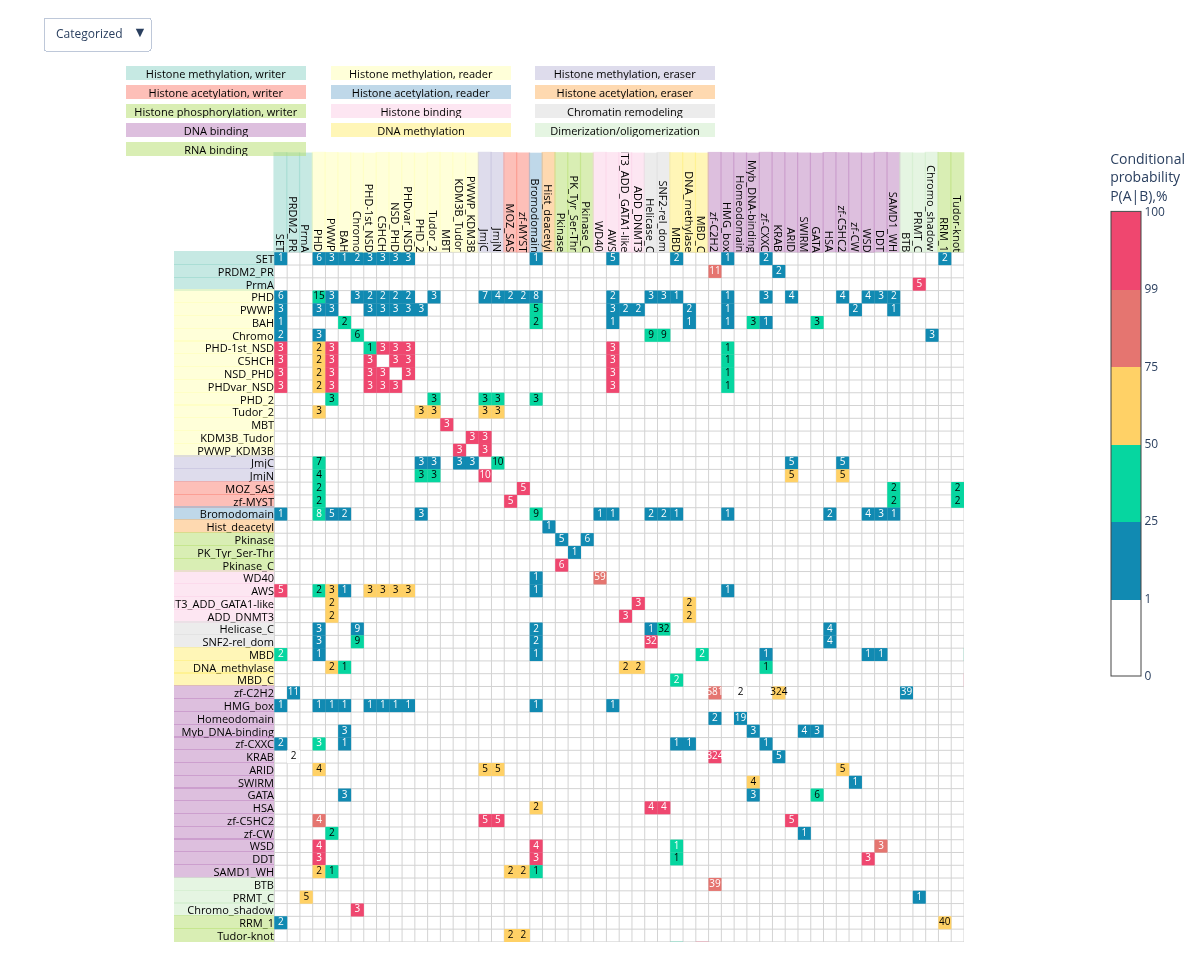

In [47]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors


n_rows, n_cols = df_cooc.shape
n_rows, n_cols = df_cooc.shape
x = np.arange(n_cols)
y = np.arange(n_rows)

x, y = np.meshgrid(x, y)

x = x.flatten()
y = y.flatten()


sizes = df_cooc_num.values.flatten()
colors = df_cooc.values.flatten()
mask = colors >0.01

def map_color(val):
    if val < 1:
        return 0
    elif val < 25:
        return 1.5*1/6
    elif val < 50:
        return 2.5*1/6
    elif val < 75:
        return 3.5*1/6
    elif val < 99:
        return 4.5*1/6
    else:
        return 5.5*1/6
def map_font_color(val):
    
    return 'black' if (25<val<75) or (val < 1) else 'white'

colorscale = [
    [0, "#ffffff"],
    [1*1/6, "#ffffff"],
    [1*1/6, "#118ab2"],
    [2*1/6, "#118ab2"],
    [2*1/6, "#06d6a0"],
    [3*1/6, "#06d6a0"],
    [3*1/6, "#ffd166"],
    [4*1/6, "#ffd166"],
    [4*1/6, "#e57570"],
    [5*1/6, "#e57570"],
    [5*1/6, "#ef476f"],
    [6*1/6, "#ef476f"],
]


color_by_cats = [map_color(val) for val in colors[mask]]
pfam_names = list(df_cooc.index)
fig = go.Figure(
    data=[
        go.Scatter(
            x=x[mask],
            y=y[mask],
            text = [int(s) for s in sizes[mask]],
            textposition='middle center',
            hoverinfo='text', 
            hovertext=[
                f"{percent:.2f}%, {num:n} proteins<br>{pfam_names[x]} - {pfam_names[y]}"
                
                for num, percent,x,y in zip(sizes[mask], colors[mask],x[mask],y[mask])
            ],
            mode="markers+text",
            marker=dict(
                color=color_by_cats,
                colorscale=colorscale,
                cmin=0,
                cmax=1,
                colorbar=dict(
                    y=0.6,
                    len=0.6,
                    tickvals=[i/6 for i in range(7)], 
                    ticktext=[0,1,25,50,75,99,100],
                    title="Conditional<br>probability<br>P(A|B),%"
                ),
                size=13,
                showscale=True,
                symbol='square', 
            ),
            textfont=dict(
                color=list(map(map_font_color ,colors[mask])),
                size=10
            )
        )
    ]
)
def get_annot(posx,posy, text,ori,bg_color,width=100,align='right',hover=True):
    c = mcolors.to_rgb(bg_color)
    return dict(
        x=posx,
        y=posy,
        text=text,
        showarrow=False,
        font=dict(
            # family="Courier New, monospace",
            size=11,
            color="black"
            ),
        
        align=align,
        valign='middle',
        height=14,
        width=width,
        xanchor='right',
        yanchor='bottom',
        textangle=0 if ori=='h' else 90,
        borderwidth=0,
        borderpad=0,
        # bordercolor=f'rgba({c[0]}, {c[1]}, {c[2]}, 0.5)',
        bgcolor=f'rgba({c[0]*255}, {c[1]*255}, {c[2]*255}, 0.5)',
        opacity=1.0,
        hovertext=f'{text}<br>{color_to_cat.get(bg_color,"white")}' if hover else None,
        name='text'
        )

annotations_y = [ get_annot(-0.5,pos+0.5,text,'h',color_nodes.get(text,'white')) for pos,text in enumerate(df_cooc.index)]
annotations_x = [ get_annot(pos+0.5,-0.5,text,'v',color_nodes.get(text,'white')) for pos,text in enumerate(df_cooc.columns)]

annotations_legend1 = [get_annot(2+ pos*16,-14+0,text,'h',color,width=180,align='center',hover=False) for pos,(text,color) in enumerate(color_cats[:3])]
annotations_legend2 = [get_annot(2+pos*16, -14+1.4,text,'h',color,width=180,align='center',hover=False) for pos,(text,color) in enumerate(color_cats[3:6])]
annotations_legend3 = [get_annot(2+pos*16, -14+2.8,text,'h',color,width=180,align='center',hover=False) for pos,(text,color) in enumerate(color_cats[6:9])]
annotations_legend4 = [get_annot(2+pos*16, -14+4.5,text,'h',color,width=180,align='center',hover=False) for pos,(text,color) in enumerate(color_cats[9:12])]
annotations_legend5 = [get_annot(2+pos*16, -14+6,text,'h',color,width=180,align='center',hover=False) for pos,(text,color) in enumerate(color_cats[12:])]


height = 960
width = 960
buttons = [dict(
            label=f"Categorized",
            method="update",
            args=[
                {"vis":True},
                {"xaxis.range": [-1,53.5],"yaxis.range": [53.5,-15], "height":height, "width":width}
                 ]
                ),
           dict(
            label=f"All",
            method="update",
            args=[
                {"vis":True},
                {"xaxis.range": [-1,162],"yaxis.range": [162,-15], "height":2000, "width":2000}
                 ]
                ),
           
          ]

fig.update_layout(height=height, width=width,#900
                 # margin=dict(t=100),
                 xaxis=dict(
                     # tickmode="array",
                    tickmode='array',
                    showgrid=False,
                    zeroline=False,
                    range=[-1, 53.5],
                    tickvals=list(range(len(df_cooc.columns))),
                    ticktext=df_cooc.columns,
                    constrain='domain',
                    scaleanchor='y', 
                    # title='Protein domains and families (by Pfam)',
                    showticklabels=False,
                    automargin=True,
                ),
                yaxis=dict(
                    tickmode='array',
                    showgrid=False,
                    zeroline=False,
                    range=[53.5,-15],
                    tickvals=list(range(len(df_cooc.index))),
                    ticktext=df_cooc.index,
                    # autorange='reversed',
                    scaleanchor='x', 
                    constrain='domain',
                    # title='Protein domains and families (by Pfam)',
                    showticklabels=False,
                    automargin=True
                ),
                  annotations=annotations_y+annotations_x+annotations_legend1+annotations_legend2+annotations_legend3+annotations_legend4+annotations_legend5,
                  margin=dict(l=150, r=30, t=50, b=1),
                  plot_bgcolor="white",
                  dragmode=False,
                  updatemenus=[
                                dict(
                                    buttons=buttons,
                                    direction="down",
                                    # active=len(buttons) - 1,
                                    x=0,
                                    y=1,
                                    showactive=True,
                                    pad={"r": 0, "t": 0},
                                    xanchor="right",
                                    yanchor="bottom",
                                ),
                            ],
                )




ticks = np.arange(-0.5, 160,1)
for x in ticks:
    fig.add_shape(
        type='line',
        x0=x, x1=x,
        y0=-0.5, y1=160 - 0.5,
        line=dict(color='lightgray', width=1),
        xref='x', yref='y', layer='below'
    )
    fig.add_shape(
        type='line',
        y0=x, y1=x,
        x0=-0.5, x1=163 - 0.5,
        line=dict(color='lightgray', width=1),
        xref='x', yref='y', layer='below'
    )


config = {
    'scrollZoom': False,  # Disable scroll to zoom
    'modeBarButtonsToRemove': ['zoom2d'],
    'displayModeBar': False,  # Hide the mode bar (toolbar)
    'doubleClick': False,  # Disable double click to reset zoom
    'editable': False,  # Disable edits like moving title and axes
    'staticPlot': False  # Disable all interactivity (makes the plot static)
}
fig.write_html("PfamvsPfam_plot.html", full_html=False,div_id='PfamvsPfam_plot',include_plotlyjs='js/plotly-2.35.2.min.js',config=config)
fig.show()

In [40]:
color_cats[12:]

[('RNA binding', '#b3de69')]